In [1]:
import random

In [2]:
import string

In [3]:
from matplotlib import animation

In [4]:
import numpy as np

In [5]:
from IPython.display import HTML

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns

In [7]:
import networkx as nx

In [8]:
from tqdm import tqdm_notebook

# Определение симуляции

In [15]:
class Simulation:
    def get_random_string(self, string_length=10):
        letters = string.ascii_lowercase
        return ''.join(random.choice(letters) for i in range(string_length))
        
    def __init__(self, trusted_nodes, malicious_nodes, iterations=5000):
        self.users = ["user{}".format(i) for i in range(trusted_nodes)] + ["hacker{}".format(i) for i in range(malicious_nodes)]
        self.graph = nx.MultiDiGraph()
        self.iterations = iterations
        
    def create_random_link(self, user, nodes_a, nodes_b):
        graph = self.graph
        try:
            node_a = random.choice(nodes_a)
            node_b = random.choice([node for node in nodes_b if node != node_a])
            weight = 1
            if ("user" in user) and ("malicious" in node_b):
                return None
            graph.add_weighted_edges_from([(node_a, node_b, weight)])
        except Exception:
            pass

    def create_content(self, user, descriptor):
        graph = self.graph
        random_string = self.get_random_string(10)
        node_name = "{}_{}_{}".format(descriptor, user, random_string)
        graph.add_node(node_name)
        return node_name

    def link_content(self, user):
        graph = self.graph
        user_content = [node for node in graph if user in node and "sybil" not in node]
        content = [node for node in graph if "sybil" not in node]
        self.create_random_link(user, user_content, content)
    
    def simulate_hacker(self, user, random_action):
        if random_action > 0.99:
            self.create_content(user, "malicious")
        elif random_action > 0.2:
            self.link_content(user)
        
    def simulate_user(self, user, random_action):
        if random_action > 0.99:
            self.create_content(user, "trusted")
        elif random_action > 0.2:
            self.link_content(user)
    
    def simulate(self):
        for user in self.users:
            random_action = random.random()
            if "hacker" in user:
                self.simulate_hacker(user, random_action)
            elif "user" in user:
                self.simulate_user(user, random_action)
                    
    def run(self):
        for i in tqdm_notebook(range(0, self.iterations)):
            self.simulate()

# Запуск симуляции (без сибилов)

In [30]:
simulation = Simulation(10, 2, 5000)
simulation.run()

# Сравнение рангов

Для графа контента

In [32]:
class MaliciousVisualizer():
    malicious = "malicious"
    trusted = "trusted"
    
    def __init__(self, graph):
        self.graph = graph
    
    def preprocess_graph_for_ranks(self):
        graph = self.graph
        plain_graph = nx.DiGraph()
        plain_graph.add_weighted_edges_from([(u, v, data["weight"]) for u, v, data in graph.edges(data=True)])
        edges = [(u, v, data["weight"]) for u, v, data in plain_graph.edges(data=True)]
        for u, v, w in edges:
            if w <= 0:
                plain_graph.remove_edge(u, v)
        return plain_graph
    
    def preprocess_graph_for_rates(self):
        graph = self.graph
        plain_graph = nx.DiGraph()
        plain_graph.add_weighted_edges_from([(u, v, 1) for u, v, _ in graph.edges])
        return plain_graph
    
    def compute_ranks(self):
        graph = self.graph
        graph = self.preprocess_graph_for_ranks()
        return nx.pagerank(graph)
    
    def calculate_rates(self):
        graph = self.graph
        graph = self.preprocess_graph_for_rates()
        return {
            node: len(list(graph.predecessors(node)))
            for node in graph
        }
    
    def visualize(self):
        graph = self.graph
        ranks = self.compute_ranks()

        rates = self.calculate_rates()
        
        malicious_ranks = np.array([(rates.get(node, 0) - 0.1, ranks.get(node, 0)) for node in graph.node if self.malicious in node])
        trusted_ranks = np.array([(rates.get(node, 0) + 0.1, ranks.get(node, 0)) for node in graph.node if self.trusted in node])

        sns.regplot(x=trusted_ranks.T[0], y=trusted_ranks.T[1], label="Trusted", color="black", marker="o")
        sns.regplot(x=malicious_ranks.T[0], y=malicious_ranks.T[1], label="Malicious", color="red", marker="x")
        plt.legend()
        
# def draw_graph(ax, graph, pos):
#     malicious_nodes = [node for node in graph.nodes if "malicious" in node]
#     sybil_nodes = [node for node in graph.nodes if "sybil" in node]
#     trusted_nodes = [node for node in graph.nodes if "trusted" in node]
#     if len(graph) > 0:
#         pos = nx.spring_layout(graph, pos=pos)
#         ranks = compute_ranks(graph)
#         nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=trusted_nodes, node_size=[1000 * ranks[node] for node in trusted_nodes], node_color="green")
#         nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=malicious_nodes, node_size=[1000 * ranks[node] for node in malicious_nodes], node_color="red")
#         nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=sybil_nodes, node_size=[1000 * ranks[node] for node in sybil_nodes], node_color="red")
#         nx.draw_networkx_edges(graph, pos, ax=ax)
#         ax.set_xticks([])
#         ax.set_yticks([])
#     return pos

(0, 0.005)

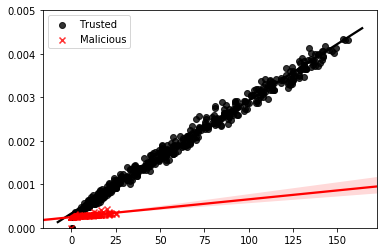

In [35]:
MaliciousVisualizer(simulation.graph).visualize()
plt.ylim(0, 0.005)

Для графа агентов

In [33]:
class AgentsMaliciousVisualizer(MaliciousVisualizer):
    malicious = "hacker"
    trusted = "user"
    
    def __init__(self, graph):
        self.total_graph = graph
        self.create_agents_graph()
    
    def get_user(self, content):
        return content.split("_")[1]
    
    def create_agents_graph(self):
        self.graph = nx.MultiDiGraph()
        self.graph.add_weighted_edges_from([(
            self.get_user(u), 
            self.get_user(v), 
            data["weight"]
        ) for u, v, data in self.total_graph.edges(data=True)])

# Запуск симуляции с сибилами и отрицательными рангами

In [38]:
class ResponsibilitySimulation(Simulation):
    def __init__(self, responsibility_rate, sybil_rate, *args):
        super().__init__(*args)
        self.responsibility_rate = responsibility_rate
        self.sybil_rate = sybil_rate
    
    def backlink_sybil(self, user):
        graph = self.graph
        sybil = self.create_content(user, "sybil")
        user_malicious_content = [node for node in graph if "malicious" in node and user in node]
        if user_malicious_content:
            content = random.choice(user_malicious_content)
            graph.add_weighted_edges_from([(sybil, content, 1), (content, sybil, 1)])
    
    def create_random_link(self, user, nodes_a, nodes_b):
        graph = self.graph
        try:
            node_a = random.choice(nodes_a)
            node_b = random.choice([node for node in nodes_b if node != node_a])
            weight = 1
            if ("user" in user) and ("malicious" in node_b):
                random_action = random.random()
                if random_action > 1 - self.responsibility_rate:
                    weight = -1
                else:
                    return None
            graph.add_weighted_edges_from([(node_a, node_b, weight)])
        except Exception:
            pass
    
    def simulate_hacker(self, user, random_action):
        if random_action > 0.99:
            self.create_content(user, "malicious")
        elif random_action > 0.99 - self.sybil_rate:
            self.backlink_sybil(user)
        elif random_action > 0.2:
            self.link_content(user)

In [39]:
simulation = ResponsibilitySimulation(1, 0.05, 100, 20, 1000)
simulation.run()

(-0.001, 0.003)

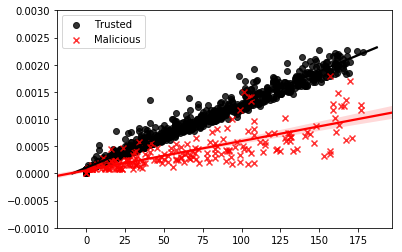

In [40]:
MaliciousVisualizer(simulation.graph).visualize()
plt.ylim(-0.001, 0.003)

Сравнение пар параметров

1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



39



40



41



42



43



44



45



46



47



48



49



50



51



52



53



54



55



56



57



58



59



60



61



62



63



64



65



66



67



68



69



70



71



72



73



74



75



76



77



78



79



80



81



82



83



84



85



86



87



88



89



90



91



92



93



94



95



96



97



98



99



100


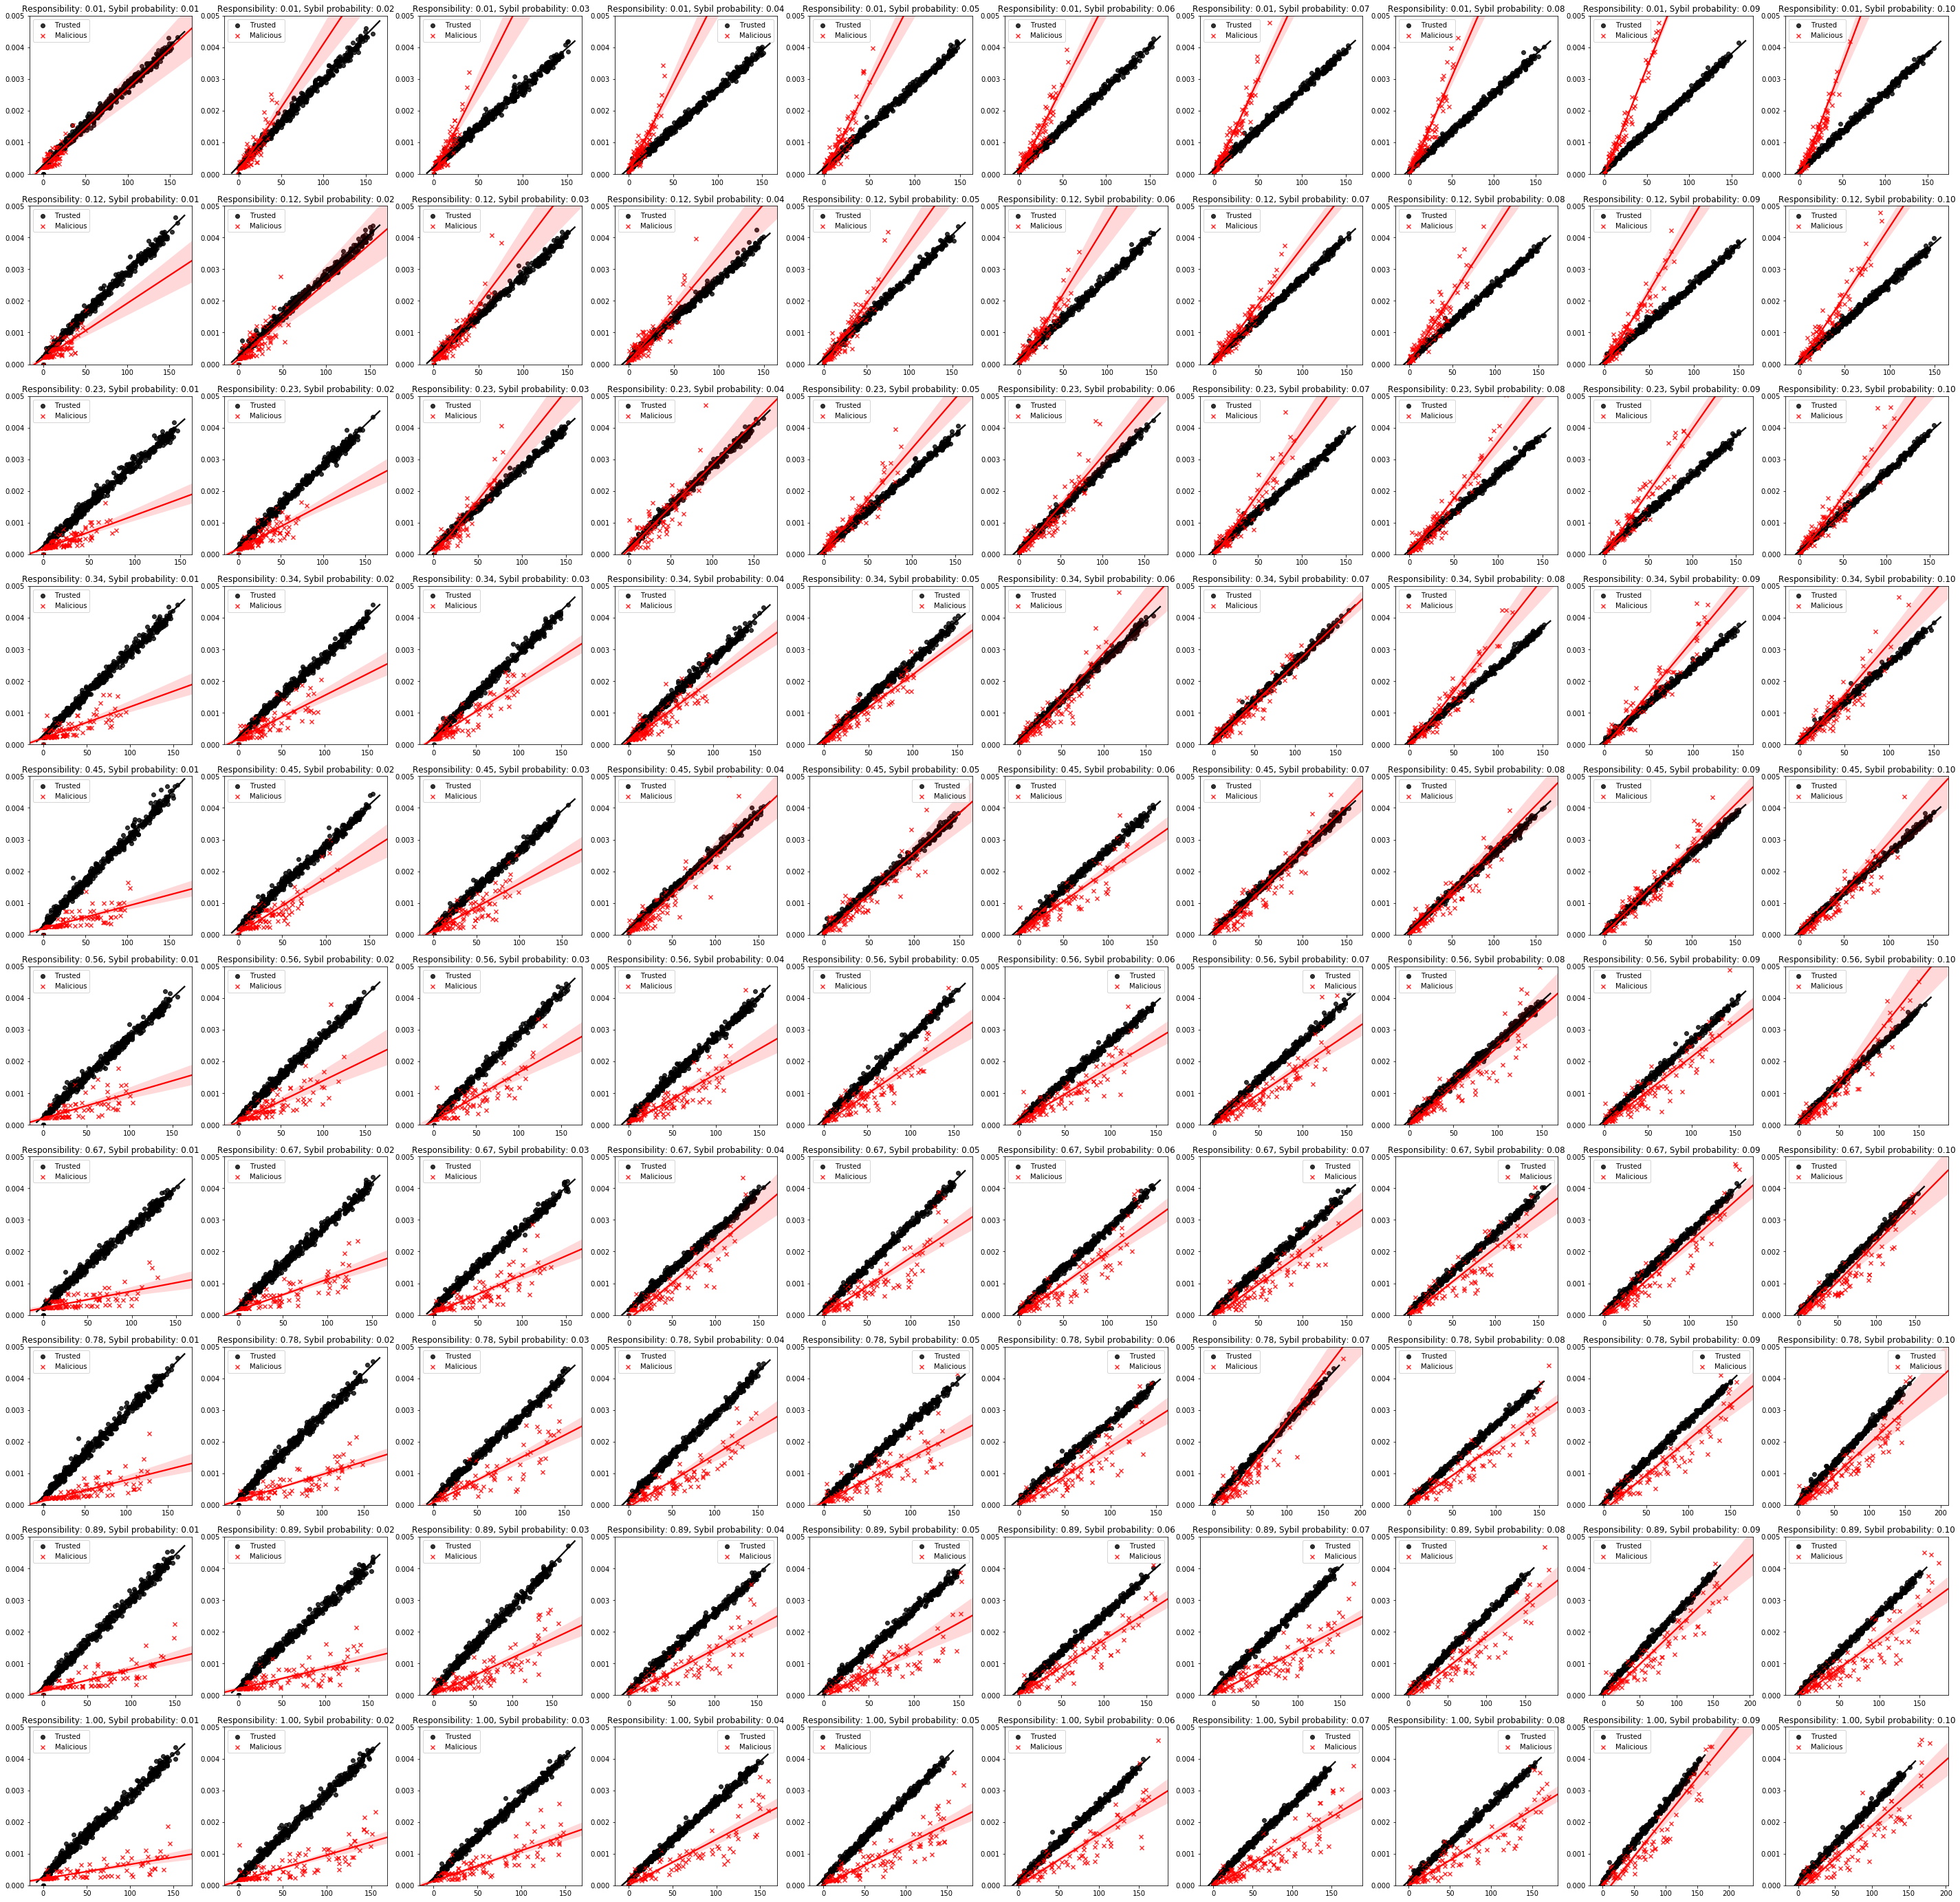

In [44]:
SIZE = 10
fig = plt.figure(figsize=(50, 50))
fig.patch.set_facecolor('white')
for i, responsibility in enumerate(np.linspace(0.01, 1, SIZE)):
    for j, sybil in enumerate(np.linspace(0.01, 0.1, SIZE)):
        index = i * SIZE + j + 1
        print(index)
        plt.subplot(SIZE, SIZE, index)
        plt.title("Responsibility: {0:.2f}, Sybil probability: {1:.2f}".format(responsibility, sybil))
        simulation = ResponsibilitySimulation(responsibility, sybil, 10, 2, 5000)
        simulation.run()
        MaliciousVisualizer(simulation.graph).visualize()
        plt.ylim(0, 0.005)
plt.show()

# Запуск симуляции с ограничениями на действия пользователя (TODO)

In [ ]:
class LimitedResponsibilitySimulation(ResponsibilitySimulation):
    actions = {
        
    }
    
    def __init__(self, *args):
        super().__init__(*args)
    
    def backlink_sybil(self, user):
        super().backlink_sybil(user)
        self.actions[user] -= 2
        
    def create_random_link(self, user, nodes_a, nodes_b):
        graph = self.graph
        try:
            node_a = random.choice(nodes_a)
            node_b = random.choice([node for node in nodes_b if node != node_a])
            weight = 1
            if ("user" in user) and ("malicious" in node_b):
                random_action = random.random()
                if random_action > 1 - self.responsibility_rate:
                    weight = -1
                else:
                    self.actions[user] += 1
                    return None
            graph.add_weighted_edges_from([(node_a, node_b, weight)])
        except Exception:
            pass
    
    def simulate_user(self, user, random_action):
        if self.actions[user] > 0:
            super().simulate_user(user, random_action)
            self.actions[user] -= 1
    
    def simulate_hacker(self, user, random_action):
        if self.actions[user] > 0:
            super().simulate_hacker(user, random_action)
            self.actions[user] -= 1
        
    def restore_actions(selfself.actions[user] -= 1
):
        for user in self.users:
            self.actions[user] = self.actions.get(user, 0) + 1
    
    def simulate(self):
        self.restore_actions()
        super().simulate()

In [ ]:
simulation = LimitedResponsibilitySimulation(0.01, 0.2, 10, 2)
simulation.run()
MaliciousVisualizer(simulation.graph).visualize()

In [ ]:
simulation = LimitedResponsibilitySimulation(0.01, 0.2, 10, 2)
simulation.run()
MaliciousVisualizer(simulation.graph).visualize()